Step 3. Run a multi-scenario optimization for GHG vs. generation-side charges.

This process creates SingleScenarioStudy and MultipleScenarioStudy objects in http://localhost:8000/admin/optimization/ along with associated DER simulations and cost calculations.

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)
sys.path.insert(0, os.getenv('PWD'))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from datetime import datetime, timedelta

from beo_datastore.libs.battery import Battery
from beo_datastore.libs.battery_schedule import create_fixed_schedule, optimize_battery_schedule
from beo_datastore.libs.plot_intervalframe import (
        plot_frame288, plot_frame288_monthly_comparison, plot_intervalframe, plot_many_frame288s
)

from cost.ghg.models import GHGRate
from cost.study.models import MultipleScenarioStudy, SingleScenarioStudy
from cost.utility_rate.models import RatePlan
from der.simulation.models import BatteryConfiguration, BatteryStrategy
from load.customer.models import CustomerCluster

See http://localhost:8888/notebooks/demo/1_create_kmeans_clusters.ipynb to create CustomerClusters and http://localhost:8888/notebooks/demo/2_create_battery_and_battery_schdule.ipynb to create BatteryConfigurations and BatterySchedules.

In [3]:
# the following steps can be also performed via Django admin at http://localhost:8000/admin/optimization/

# create multi-scenario optimization
multi = MultipleScenarioStudy.objects.create()

# create simulation optimizations and add them to a multi-scenario optimization
for config in [BatteryConfiguration.objects.first()]:
    for strategy in [BatteryStrategy.objects.first(), BatteryStrategy.objects.last()]:
        single, _ = SingleScenarioStudy.objects.get_or_create(
            start=datetime(2018, 1, 1),
            end_limit=datetime(2019, 1, 1),
            der_strategy=strategy,
            der_configuration=config,
            rate_plan=RatePlan.objects.filter(name__contains="E-19").first(),
        )
        single.meter_groups.add(CustomerCluster.objects.first())
        single.ghg_rates.add(*GHGRate.objects.filter(name="Clean Net Short"))
        single.ghg_rates.add(*GHGRate.objects.filter(name="CARB - Unspecified Power"))
        multi.single_scenario_studies.add(single)

In [4]:
# as an alternative, you can retrieve an existing multi-scenario optimization
# multi = MultipleScenarioStudy.objects.get(id=1)

In [5]:
# this step kicks off all battery simulations and cost calculations
multi.run(multiprocess=True)

In [6]:
# display all bill and GHG impacts from every single simulation optimization
display(multi.detailed_report)

,UsagePreDER,UsagePostDER,UsageDelta,BillPreDER,BillPostDER,BillDelta,CleanNetShort2018PreDER,CleanNetShort2018PostDER,CleanNetShort2018Delta,CleanNetShort2022PreDER,...,CleanNetShort2030Delta,CARB-UnspecifiedPower2013PreDER,CARB-UnspecifiedPower2013PostDER,CARB-UnspecifiedPower2013Delta,SingleScenarioStudy,BatteryConfiguration,DERStrategy,SimulationRatePlan,Location,Building Type
ID,,,,,,,,,,,,,,,,,,,,,
0199af58-b899-400e-b3f7-3fb573da4349,5.827266e+06,5.852049e+06,24783.333333,8.909138e+05,8.720945e+05,-18819.328881,2243.323362,2255.352528,12.029166,1767.505207,...,68.386524,2494.069911,2504.677178,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Monterey NAF,Large Office
0199af58-b899-400e-b3f7-3fb573da4349,5.827266e+06,5.859766e+06,32500.000000,8.909138e+05,9.038009e+05,12887.074969,2243.323362,2253.541211,10.217849,1767.505207,...,-27.546635,2494.069911,2507.979911,13.910000,2,150kW @ 4 hours (90.0% efficiency),Minimize Clean Net Short 2030 - charge thresho...,"E-19 (Primary, Voluntary)",Monterey NAF,Large Office
058e5bfa-c2de-4527-b07c-67ac0956dead,7.037353e+06,7.062137e+06,24783.333333,1.026441e+06,1.005535e+06,-20905.910045,2709.839769,2721.868935,12.029166,2154.254299,...,68.386524,3011.987234,3022.594501,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Palm Springs Intl AP,Large Office
058e5bfa-c2de-4527-b07c-67ac0956dead,7.037353e+06,7.069853e+06,32500.000000,1.026441e+06,1.037646e+06,11205.706946,2709.839769,2720.057618,10.217849,2154.254299,...,-27.546635,3011.987234,3025.897234,13.910000,2,150kW @ 4 hours (90.0% efficiency),Minimize Clean Net Short 2030 - charge thresho...,"E-19 (Primary, Voluntary)",Palm Springs Intl AP,Large Office
0762f6ec-e57e-4f47-9879-5266d66265a5,6.471160e+06,6.495943e+06,24783.333333,9.601441e+05,9.402952e+05,-19848.940959,2490.804297,2502.833463,12.029166,1965.181354,...,68.386524,2769.656446,2780.263713,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Barstow Daggett AP,Large Office
0762f6ec-e57e-4f47-9879-5266d66265a5,6.471160e+06,6.503660e+06,32500.000000,9.601441e+05,9.686650e+05,8520.881736,2490.804297,2501.022146,10.217849,1965.181354,...,-27.546635,2769.656446,2783.566446,13.910000,2,150kW @ 4 hours (90.0% efficiency),Minimize Clean Net Short 2030 - charge thresho...,"E-19 (Primary, Voluntary)",Barstow Daggett AP,Large Office
0a665556-92ee-478b-b04e-600ff509f5fb,6.485261e+06,6.510044e+06,24783.333333,9.664918e+05,9.466782e+05,-19813.548582,2496.342582,2508.371747,12.029166,1962.760989,...,68.386524,2775.691523,2786.298789,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Van Nuys AP,Large Office
0a665556-92ee-478b-b04e-600ff509f5fb,6.485261e+06,6.517761e+06,32500.000000,9.664918e+05,9.770167e+05,10524.886936,2496.342582,2506.560430,10.217849,1962.760989,...,-27.546635,2775.691523,2789.601523,13.910000,2,150kW @ 4 hours (90.0% efficiency),Minimize Clean Net Short 2030 - charge thresho...,"E-19 (Primary, Voluntary)",Van Nuys AP,Large Office
0da824ae-bf65-41eb-bd9d-2eed2f33b4d6,6.035521e+06,6.060304e+06,24783.333333,9.125676e+05,8.951532e+05,-17414.341490,2321.154803,2333.183968,12.029166,1838.274599,...,68.386524,2583.202803,2593.810070,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Edwards AFB,Large Office


In [7]:
# this step can be run using different filtering criteria

# remove all existing filters
multi.initialize()

# filter simulations
multi.filter_by_query("BillDelta < -1")  # include only BillDelta < -1
multi.filter_by_transform("CleanNetShort2030Delta", min)  # limit results to min CleanNetShort2030Delta values 

In [8]:
# display bill and GHG impacts
display(multi.detailed_report)

,UsagePreDER,UsagePostDER,UsageDelta,BillPreDER,BillPostDER,BillDelta,CleanNetShort2018PreDER,CleanNetShort2018PostDER,CleanNetShort2018Delta,CleanNetShort2022PreDER,...,CleanNetShort2030Delta,CARB-UnspecifiedPower2013PreDER,CARB-UnspecifiedPower2013PostDER,CARB-UnspecifiedPower2013Delta,SingleScenarioStudy,BatteryConfiguration,DERStrategy,SimulationRatePlan,Location,Building Type
0199af58-b899-400e-b3f7-3fb573da4349,5.827266e+06,5.852049e+06,24783.333333,8.909138e+05,8.720945e+05,-18819.328881,2243.323362,2255.352528,12.029166,1767.505207,...,68.386524,2494.069911,2504.677178,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Monterey NAF,Large Office
058e5bfa-c2de-4527-b07c-67ac0956dead,7.037353e+06,7.062137e+06,24783.333333,1.026441e+06,1.005535e+06,-20905.910045,2709.839769,2721.868935,12.029166,2154.254299,...,68.386524,3011.987234,3022.594501,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Palm Springs Intl AP,Large Office
0762f6ec-e57e-4f47-9879-5266d66265a5,6.471160e+06,6.495943e+06,24783.333333,9.601441e+05,9.402952e+05,-19848.940959,2490.804297,2502.833463,12.029166,1965.181354,...,68.386524,2769.656446,2780.263713,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Barstow Daggett AP,Large Office
0a665556-92ee-478b-b04e-600ff509f5fb,6.485261e+06,6.510044e+06,24783.333333,9.664918e+05,9.466782e+05,-19813.548582,2496.342582,2508.371747,12.029166,1962.760989,...,68.386524,2775.691523,2786.298789,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Van Nuys AP,Large Office
0da824ae-bf65-41eb-bd9d-2eed2f33b4d6,6.035521e+06,6.060304e+06,24783.333333,9.125676e+05,8.951532e+05,-17414.341490,2321.154803,2333.183968,12.029166,1838.274599,...,68.386524,2583.202803,2593.810070,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Edwards AFB,Large Office
104e04be-b496-4b75-a7a1-e550606e1899,6.208285e+06,6.233068e+06,24783.333333,9.351175e+05,9.165603e+05,-18557.174906,2388.371588,2400.400754,12.029166,1887.516760,...,68.386524,2657.145990,2667.753257,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Porterville AWOS,Large Office
1788025b-0abf-4518-8eff-47187e9b996c,6.392201e+06,6.416984e+06,24783.333333,9.512923e+05,9.336693e+05,-17622.970237,2459.977672,2472.006838,12.029166,1923.925995,...,68.386524,2735.861948,2746.469215,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Chino AP,Large Office
1821073e-be3c-4449-9ef3-455776a5a82e,6.351915e+06,6.376698e+06,24783.333333,9.458881e+05,9.291378e+05,-16750.283494,2443.990561,2456.019726,12.029166,1909.149314,...,68.386524,2718.619411,2729.226678,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Chula Vista-Brown Field Muni AP,Large Office
1b234335-2499-4b92-bc1a-9f307d21cd3b,6.607356e+06,6.632140e+06,24783.333333,9.680930e+05,9.513849e+05,-16708.060882,2545.038459,2557.067625,12.029166,1996.365547,...,68.386524,2827.948544,2838.555811,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",San Diego-Lindbergh Field,Large Office
1c532bb5-243a-4ead-a309-fc53b323d67f,5.831693e+06,5.856476e+06,24783.333333,8.911262e+05,8.739748e+05,-17151.480566,2243.840960,2255.870126,12.029166,1776.895869,...,68.386524,2495.964498,2506.571764,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge threshol...,"E-19 (Primary, Voluntary)",Sandberg,Large Office


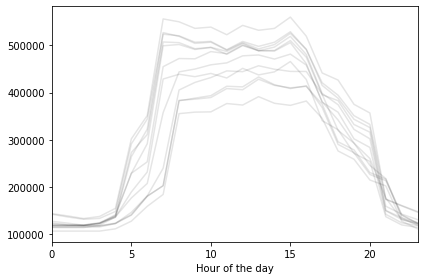

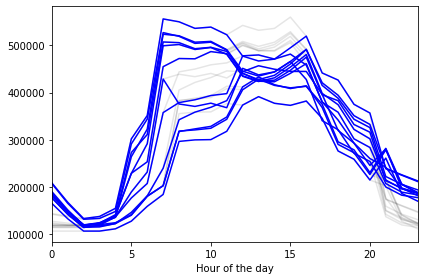

In [9]:
# plot all meters in study (combined into a single load profile)
frame288_type = "total_frame288"

# plot all meters combined before battery
plot_frame288(multi.pre_der_intervalframe.total_frame288)
# compare all meteres combined after battery with before battery
plot_many_frame288s(
    [getattr(multi.pre_der_intervalframe, frame288_type)],
    getattr(multi.post_der_intervalframe, frame288_type),
)

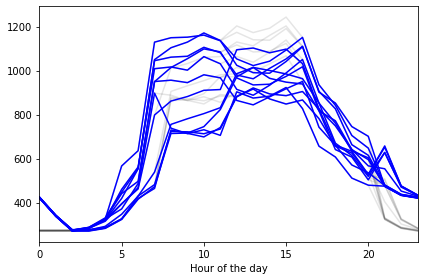

None

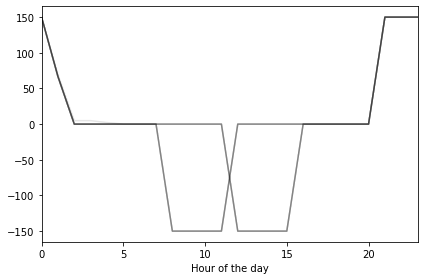

None

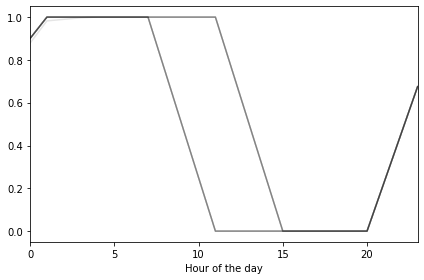

None

In [10]:
id_ = "0199af58-b899-400e-b3f7-3fb573da4349"

# examine battery operations for a single meter
battery_simulation = multi.der_simulations.get(meter__id=id_)

# display average daily load before battery
display(plot_many_frame288s(
    [battery_simulation.pre_intervalframe.average_frame288],
    battery_simulation.post_intervalframe.average_frame288
))

# display average battery discharge
display(plot_frame288(battery_simulation.intervalframe.average_frame288))

# display average battery state of charge
display(plot_frame288(battery_simulation.average_state_of_charge_frame288))

In [11]:
# view individual before and after bills
bill_calculation = multi.bill_calculations.get(der_simulation__meter__id=id_)
bill_comparison = bill_calculation.bill_comparisons.get(start=datetime(2018, 7, 1))

display(bill_comparison.pre_DER_validation_bill.total_dataframe)
display(bill_comparison.post_DER_validation_bill.total_dataframe)

,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,fixed,Fixed Charge First Meter,,1.000000,month,140,$/month,1,140.000000
1,energy,Energy Charge,1,235917.720356,kWh,0.07369,$/kWh,1,17384.776813
2,energy,Energy Charge,3,138634.176299,kWh,0.09849,$/kWh,1,13654.080024
3,energy,Energy Charge,4,141884.691058,kWh,0.14013,$/kWh,1,19882.301758
4,demand,Demand Charge,2,1424.311103,kW,3.56,$/kW,1,5070.547528
5,demand,Demand Charge,3,1469.110173,kW,16.67,$/kW,1,24490.066584
6,demand,Flat Demand Charge,0,1469.110173,kW,9.72,$/kW,1,14279.750882
Total,,,,520800.119162,,,,,94901.523588


,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,fixed,Fixed Charge First Meter,,1.000000,month,140,$/month,1,140.000000
1,energy,Energy Charge,1,251184.387022,kWh,0.07369,$/kWh,1,18509.777480
2,energy,Energy Charge,3,138634.176299,kWh,0.09849,$/kWh,1,13654.080024
3,energy,Energy Charge,4,128684.691058,kWh,0.14013,$/kWh,1,18032.585758
4,demand,Demand Charge,2,1424.311103,kW,3.56,$/kW,1,5070.547528
5,demand,Demand Charge,3,1366.168094,kW,16.67,$/kW,1,22774.022126
6,demand,Flat Demand Charge,0,1442.564180,kW,9.72,$/kW,1,14021.723827
Total,,,,522737.297756,,,,,92202.736742


In [12]:
# view individual before and after monthly GHG emissions
ghg_calculation = multi.ghg_calculations.get(der_simulation__meter__id=id_, ghg_rate__name="Clean Net Short", ghg_rate__effective__year=2030)
display(ghg_calculation.aggregate_ghg_calculation.comparison_table)

,before,after
1,112.109965,117.603820
2,84.827634,90.076157
3,110.364527,116.340744
4,80.021725,87.974627
5,98.123070,103.952542
6,93.332957,100.834061
7,109.519051,115.386746
8,141.045743,145.110853
9,157.197258,160.772158
10,110.771153,116.320636
